# 10分钟快速上手飞桨

从完成一个简单的『手写数字识别任务』开始，可快速了解深度学习模型开发的大致流程，并初步掌握飞桨框架 API 的使用方法。


## 快速安装飞桨

如果已经安装好飞桨那么可以跳过此步骤。飞桨支持很多种安装方式，这里介绍其中一种简单的安装命令：

```bash
# 使用 pip 工具安装飞桨 CPU 版
python3 -m pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple --trusted-host
```

该命令用于安装CPU版本的飞桨，如果要安装其他计算平台或操作系统支持的版本，可点击 [ 快速安装]( <https://www.paddlepaddle.org.cn/install/quick>)  查看安装引导。

### 导入飞桨

安装完成后，需要在Python解释器中使用 import 导入飞桨，即可开始实践深度学习任务。

若操作成功，会输出飞桨的版本号。

In [1]:
import paddle    
print(paddle.__version__)

2.2.0




## 实践：手写数字识别任务

手写数字识别是深度学习里的 Hello Word 任务，其目标是输入手写数字的图片，输出这个图片中的数字。本任务中用到的数据集为MNIST手写数字数据集，该手写数字数据集包含60000张训练图片和10000张测试图片，这些图片是从0~9的手写数字，分辨率为28*28。数据集中部分图像和对应的分类标签如下图所示。
![](images/mnist.png)

开始之前，需要使用下面的代码安装matplotlib和numpy

```bash
python3 -m pip install matplotlib numpy -i https://mirror.baidu.com/pypi/simple
```

如果想直接运行代码，可以拷贝下面的完整代码到一个Python文件中进行运行。

完整代码如下:

In [2]:
import paddle
import numpy as np
from paddle.vision.transforms import ToTensor

# 下载数据集并初始化DataSet
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=ToTensor())
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=ToTensor())

# 初始化网络
lenet = paddle.vision.models.LeNet(num_classes=10)
model = paddle.Model(lenet)

# 模型训练相关配置，准备损失计算方法，优化器和精度计算方法
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()), 
              paddle.nn.CrossEntropyLoss(),
              paddle.metric.Accuracy())

# 模型训练
model.fit(train_dataset, epochs=5, batch_size=64, verbose=1)
# 模型评估
model.evaluate(test_dataset, verbose=1)

# 保存模型
model.save('./output/mnist')
# 加载模型
model.load('output/mnist')

# 从测试集中取出一张图片并将图片shape变为1*1*28*28
img, label = test_dataset[0]
img_batch = np.expand_dims(img.astype('float32'), axis=0)

# 执行推理并打印结果
out = model.predict_batch(img_batch)[0]
pred_label = out.argmax()
print('true label: {}, pred label: {}'.format(label[0], pred_label))

简单的说，深度学习任务一般分为以下几个核心步骤：


1. 数据集定义与加载；
2. 模型组网；
3. 模型训练和评估；
5. 模型预测。

接下来逐个步骤介绍，帮助你快速掌握使用飞桨框架API实践深度学习任务的方法。


###  数据集定义与加载

Paddle 在 paddle.vision.dataset 下提供了 CV 领域常见的数据集,如Cifar10,Cifar100,FashionMNIST,MNIST和VOC2012等，如果你想了解更多，点击 [paddle.vision.dataset文档](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#api)。

在本任务中，直接加载飞桨框架的内置的MNIST手写数字数据集。这里加载两个数据集，一个用来训练模型，一般叫做训练集；一个用来测试模型，一般叫做测试集。

在下面的代码中，导入了`paddle.vision.transforms`模块，`paddle.vision.transforms` 里内置了很多和数据处理相关的api，如对图像进行中心裁剪、水平翻转图像和对图像进行归一化，详细的api信息可以在[paddle.vision.transforms文档](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#about-transforms)查看 


In [4]:
import paddle
from paddle.vision.transforms import ToTensor

# 下载数据集并初始化DataSet
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=ToTensor())
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=ToTensor())
# 打印数据集里图片数量
print('{} images in train_dataset, {} images in test_dataset'.format(len(train_dataset), len(test_dataset)))

60000 images in train_dataset, 10000 images in test_dataset


###  模型组网

飞桨的模型组网有两种方式，一种是使用飞桨内置的模型来直接进行模型的组网和初始化，一种是使用内置的 [paddle.nn.Layer](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/Layer_cn.html#layer) api来进行灵活度更高的组网。

由于MNIST数据集比较简单，普通的神经网络就能够达到很高的精度，因此在本任务中使用飞桨内置的LeNet作为模型，LeNet作为 [paddle.vision.models](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#about-models) 的内置模型，可以很方便的调用它，只需要下面这句话即可完成LeNet的网络构建和初始化。

In [5]:
# 初始化网络
lenet = paddle.vision.models.LeNet(num_classes=10)

### 模型训练评估

#### 模型训练

在训练模型前，需要配置训练模型时的损失函数与优化方法，因为是分类任务，这里损失函数使用常见的 [CrossEntropyLoss](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/nn/CrossEntropyLoss_cn.html#crossentropyloss) (交叉熵损失函数)，优化器使用常见的 [Adam](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/optimizer/Adam_cn.html#adam) 优化器，使用 [Accuracy](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/metric/Accuracy_cn.html#accuracy) 指标来计算网络在训练集上的精度。在训练过程中可以使用飞桨框架高层API- [paddle.Model.fit()](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/Model_cn.html#fit-train-data-none-eval-data-none-batch-size-1-epochs-1-eval-freq-1-log-freq-10-save-dir-none-save-freq-1-verbose-2-drop-last-false-shuffle-true-num-workers-0-callbacks-none) 来自动完成模型的训练循环，具体代码如下。

In [7]:
# 初始化paddle.Model模型，便于进行后续的配置、训练和验证
model = paddle.Model(lenet)

# 模型训练相关配置，准备损失计算方法，优化器和精度计算方法
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()), 
              paddle.nn.CrossEntropyLoss(),
              paddle.metric.Accuracy())

# 开始模型
model.fit(train_dataset, epochs=5, batch_size=64, verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5
step 938/938 [==============================] - loss: 0.0312 - acc: 0.9869 - 16ms/step          
Epoch 2/5
step 938/938 [==============================] - loss: 0.0414 - acc: 0.9889 - 16ms/step          
Epoch 3/5
step 938/938 [==============================] - loss: 2.4796e-04 - acc: 0.9904 - 16ms/step      
Epoch 4/5
step 938/938 [==============================] - loss: 9.6802e-04 - acc: 0.9919 - 16ms/step      
Epoch 5/5
step 938/938 [==============================] - loss: 0.0047 - acc: 0.9922 - 16ms/step            


#### 模型评估

模型训练完成之后，可以使用预先定义的测试数据集来评估训练得到的模型的精度。评估完成会输出模型在测试集上的loss和精度。

可以看到，初步训练得到的模型精度在98%附近，在逐渐了解飞桨后，可以通过调整其中的训练参数来提升模型的精度。


In [8]:
# 进行模型评估
model.evaluate(test_dataset, verbose=1)

Eval begin...
step 10000/10000 [==============================] - loss: 1.1921e-07 - acc: 0.9800 - 2ms/step          - loss: 0
Eval samples: 10000


{'loss': [1.1920929e-07], 'acc': 0.98}

### 模型预测

在普遍的离线预测场景下，完成训练完成后，需要将模型进行保存，然后再进行模型加载之后进行预测。因此，本次的推理过程如下：

1. 保存模型
1. 加载模型
2. 从测试集中选择一张图片作为输入
3. 进行推理并输出结果


模型训练完成之后，可以通过如下命令进行保存，在下面的命令中，output为模型保存的文件夹名称，minst为模型保存的文件名称

In [9]:
# 保存模型，文件夹会自动创建
model.save('./output/mnist')

模型保存会在`output`目录下保存两个文件，`mnist.pdopt`为优化器的参数，`mnist.pdparams`为网络的参数
```bash
output
├── mnist.pdopt     # 优化器的参数
└── mnist.pdparams  # 网络的参数
```
模型保存完成后，通过下面的命令进行模型加载和预测

true label: 7, pred label: 7


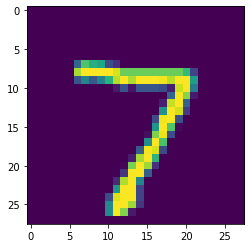

In [10]:
# 加载模型
model.load('output/mnist')

# 从测试集中取出一张图片并将图片shape变为1*1*28*28
img, label = test_dataset[0]
img_batch = np.expand_dims(img.astype('float32'), axis=0)

# 执行推理并打印结果
out = model.predict_batch(img_batch)[0]
pred_label = out.argmax()
print('true label: {}, pred label: {}'.format(label[0], pred_label))
# 可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0])

至此你就通过飞桨几个简单的API完成了一个深度学习任务，你也可以针对自己的需求来更换其中的代码，比如对数据集使用更多的数据增强、使用更大的 CNN 模型和自定义的神经网络等，飞桨官网提供了丰富的教程与案例可供参考